In [1]:
%matplotlib inline
import yfinance as yf
import datetime
import os
from full_fred.fred import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

import warnings
warnings.filterwarnings("ignore")

In [2]:
start_sp = datetime.datetime(2014,1,1)
end_sp = datetime.datetime(2019,12,31)

In [3]:
sp500 = yf.download('SPY', start_sp, end_sp).reset_index()

[*********************100%***********************]  1 of 1 completed


In [4]:
os.environ['FRED_API_KEY'] = 'deae4de87b5ad7edf259d3ae938c02a7'
fred = Fred()
fred.env_api_key_found()

True

In [5]:
effr = fred.get_series_df('EFFR')

In [6]:
effr['value'] = effr['value'].replace('.', np.nan)

In [7]:
effr['value'] = effr['value'].fillna(method="ffill")

In [8]:
effr['date'] = effr['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [9]:
effr_df = effr.loc[(start_sp < effr['date']) & (effr['date'] < end_sp)][['date', 'value']].reset_index(drop = True)

In [10]:
# Convert to daily and ajust for 252 trading days
dc = 1/25200
effr_df['daily_rate'] = pd.to_numeric(effr_df['value']) * dc

In [11]:
sp500 = sp500.rename(columns = {'Date' : 'date'})

In [12]:
DF = pd.merge(sp500, effr_df, how = 'left').set_index('date')

In [13]:
DF['simple_return'] = DF['Close'].pct_change()
DF['excess_return'] = DF['simple_return'] - DF['daily_rate']

In [14]:
DF.head()

,Open,High,Low,Close,Adj Close,Volume,value,daily_rate,simple_return,excess_return
date,,,,,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,154.400269,119636900,0.08,0.000003,NaN,NaN
2014-01-03,183.229996,183.600006,182.630005,182.889999,154.374939,81390600,0.08,0.000003,-0.000164,-0.000167
2014-01-06,183.490005,183.559998,182.080002,182.360001,153.927551,108028200,0.08,0.000003,-0.002898,-0.002901
2014-01-07,183.089996,183.789993,182.949997,183.479996,154.872910,86144200,0.07,0.000003,0.006142,0.006139
2014-01-08,183.449997,183.830002,182.889999,183.520004,154.906677,96582300,0.07,0.000003,0.000218,0.000215


In [15]:
# Split data into training and test sets
split = int(len(DF) * 0.7)
train_data = DF.iloc[:split]
test_data = DF.iloc[split:]

(b) Plot the SPDR return time series, the EFFR, and the excess return per unit of SPDR, starting from t = 0 corresponding to 1 Jan 2014.

Text(0.5, 1.0, 'SPDR return time series')

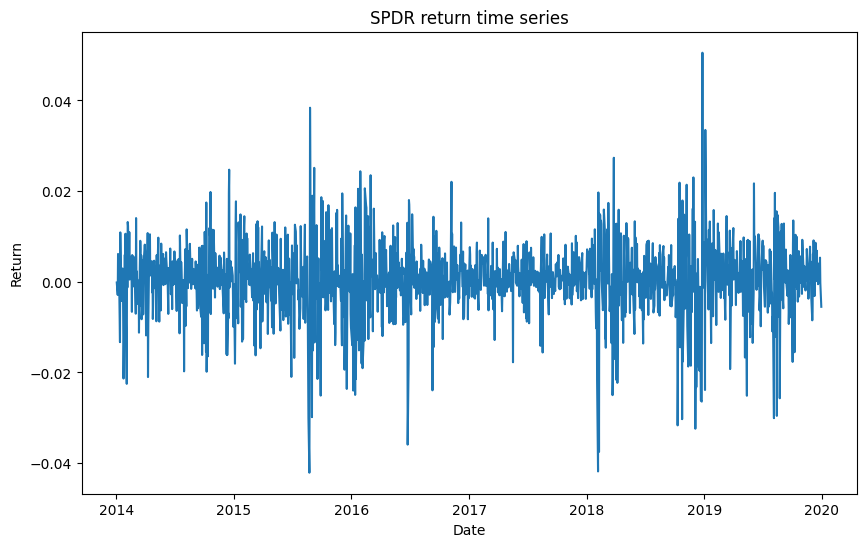

In [16]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(DF.index, DF['simple_return'])
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title('SPDR return time series')

Text(0.5, 1.0, 'EFFR')

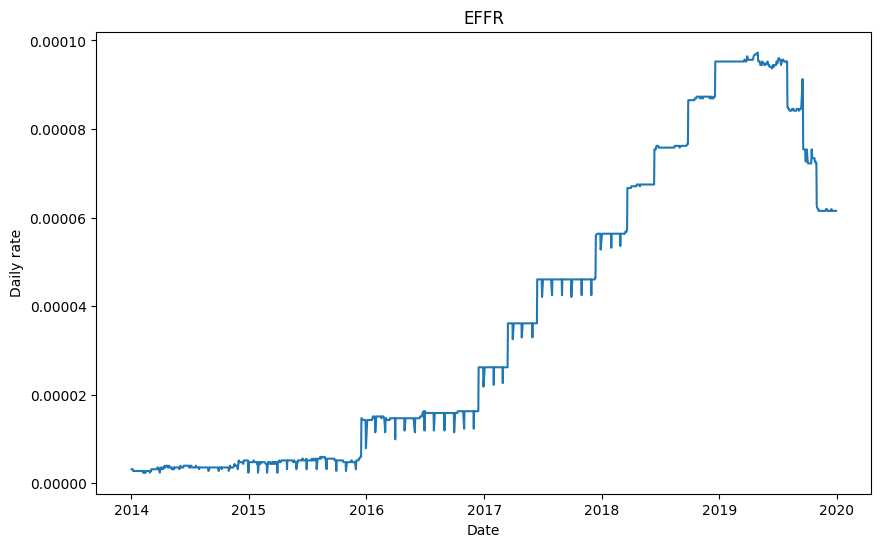

In [17]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(DF.index, DF['daily_rate'])
ax.set_xlabel('Date')
ax.set_ylabel('Daily rate')
ax.set_title('EFFR')

Text(0.5, 1.0, 'Excess return per unit of SPDR')

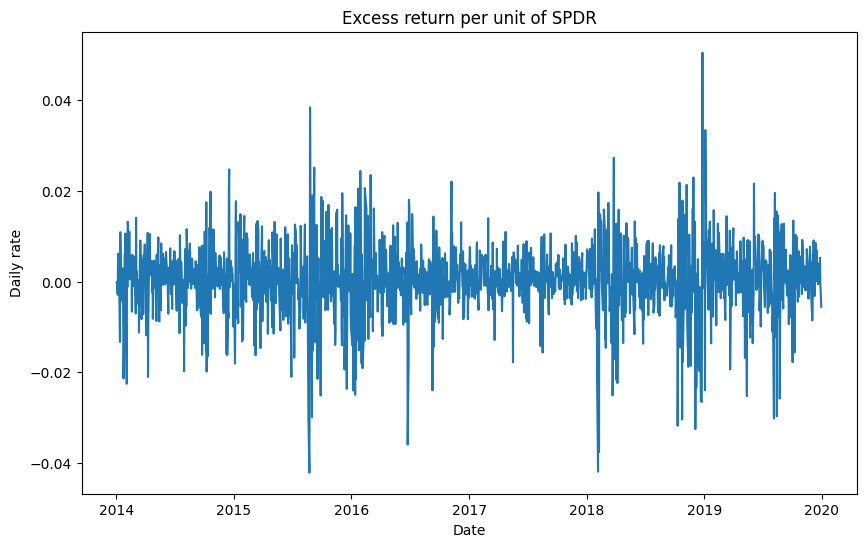

In [18]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(DF.index, DF['excess_return'])
ax.set_xlabel('Date')
ax.set_ylabel('Daily rate')
ax.set_title('Excess return per unit of SPDR')

# Autoregressive model

In [19]:
V0 = 200000
L = 5

In [28]:
def ar_mean_reversion(df):
    
    time_window = 30
    cumsum = [0]
    ar_prediction = np.zeros(np.shape(df['Close'].values))
    units = np.zeros(np.shape(df['Close'].values))
    w = np.zeros(np.shape(df['Close'].values))
    cash = np.zeros(np.shape(df['Close'].values))
    vt = np.zeros(np.shape(df['Close'].values))

    cash[0] = V0*L
    vt[0] = V0

    for i, x in enumerate(df['Close'].values[:-1], 0):
        cumsum.append(cumsum[i] + x)
        ar_prediction[i] = x
        if i>=time_window:
            X = df['Close'].values[i-time_window:i]
            train = X
            # Autoregression
            model = AutoReg(train, lags=min(time_window-1, 5))
            model_fit = model.fit()
            predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
            ar_prediction[i] = predictions[0]

        if ar_prediction[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]
            units[i+1] = units[i]
            
        # Buy signal
        if ar_prediction[i] > x: 
            units[i+1] = cash[i]/x 
            w[i+1] = cash[i]/x + w[i]
            cash[i+1] = 0
        
        # Sell signal
        if ar_prediction[i] < x:
            units[i+1] = w[i]
            cash[i+1] = w[i]*x + cash[i]
            w[i+1] = 0

        vt[i+1] = w[i+1]*x + cash[i+1]
        ar_prediction[i+1] = df['Close'].values[len(df)-1]
        
    df['vt'] = vt
    df['position'] = np.where(ar_prediction > df ['Close'].values, -1, 1)

    df['theta'] = np.clip(units * df['Close'] * df['position'], -vt * L, vt * L)
    df['pnl'] = df['excess_return'] * df['theta']

    df['strategy'] = [a*b for a,b in zip(w, df['Close'].values)] + cash

    return df


In [29]:
train_df_ar = ar_mean_reversion(train_data.copy())
test_df_ar = ar_mean_reversion(test_data.copy())

# SMA Crossover

In [30]:
def sma_crossover(df):
    
    sma_short = 30 
    sma_long = 70
    
    units = np.zeros(np.shape(df['Close'].values))
    w = np.zeros(np.shape(df['Close'].values))
    cash = np.zeros(np.shape(df['Close'].values))
    vt = np.zeros(np.shape(df['Close'].values))
    
    cash[0] = V0*L
    units[0] = cash[0]/df['Close'][0]
    w[0] = units[0]*df['Close'][0]
    vt[0] = V0
    
    sma_short_arr = df['Close'].rolling(window=sma_short).mean()
    sma_long_arr = df['Close'].rolling(window=sma_long).mean()
    
        
    for i in range(1, len(df)):
        if sma_short_arr[i-1] < sma_long_arr[i-1] and sma_short_arr[i] >= sma_long_arr[i]:
            # Buy signal
            units[i] = cash[i-1]/df['Close'][i]
            w[i] = units[i]*df['Close'][i]
            cash[i] = 0
        elif sma_short_arr[i-1] > sma_long_arr[i-1] and sma_short_arr[i] <= sma_long_arr[i]:
            # Sell signal
            cash[i] = units[i-1]*df['Close'][i]
            units[i] = 0
            w[i] = 0
        else:
            # No action
            units[i] = units[i-1]
            w[i] = w[i-1]
            cash[i] = cash[i-1]
        vt[i] = w[i] + cash[i]
    
    df['vt'] = vt
    df['position'] = -1
    df['position'][sma_short:] = np.where(sma_short_arr[sma_short:] > sma_long_arr[sma_short:], 1, -1)
    df['theta'] = np.clip(units * df['Close'] * df['position'], -vt * L, vt * L)
    df['pnl'] = df['excess_return'] * df['theta']
    df['strategy'] = [a*b for a,b in zip(w, df['Close'].values)] + cash
    
    return df

In [31]:
train_df_sma = sma_crossover(train_data.copy())
test_df_sma = sma_crossover(test_data.copy())

# Moving average mean reversion Strategy

In [32]:
def mean_reversion(df):
    
    time_window = 30
    cumsum = [0]

    ma = np.zeros(np.shape(df['Close'].values))
    units = np.zeros(np.shape(df['Close'].values))
    w = np.zeros(np.shape(df['Close'].values))
    cash = np.zeros(np.shape(df['Close'].values))
    vt = np.zeros(np.shape(df['Close'].values))

    cash[0] = V0*L
    vt[0] = V0

    for i, x in enumerate(df['Close'].values[:-1], 0):
        cumsum.append(cumsum[i] + x)
        ma[i] = x
        if i>=time_window:
            moving_ave = (cumsum[i+1] - cumsum[i+1-time_window])/(time_window)
            ma[i] = moving_ave

        if ma[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]
            units[i+1] = units[i]

        if ma[i] > x: 
            units[i+1] = cash[i]/x 
            w[i+1] = cash[i]/x   + w[i]
            cash[i+1] = 0

        if ma[i] < x:
            units[i+1] = w[i]
            cash[i+1] = w[i]*x + cash[i]
            w[i+1] = 0

        vt[i+1] = w[i+1]*x + cash[i+1]
        ma[i+1] = df['Close'].values[len(df)-1]
    
    df['vt'] = vt
    df['position'] = np.where(ma > df['Close'].values, -1, 1)

    df['theta'] = units * df['Close'] *df['position']
    df['theta'] = np.clip(units * df['Close'] * df['position'], -vt * L, vt * L)
    df['pnl'] = df['excess_return'] * df['theta']

    df['strategy'] = [a*b for a,b in zip(w, df['Close'].values)] + cash
    
    return df

In [33]:
train_df_mr = mean_reversion(train_data.copy())
test_df_mr = mean_reversion(test_data.copy())

(b) Plot the position of the strategies θt together with the upper and lower bounds [−Vt · L, Vt · L].

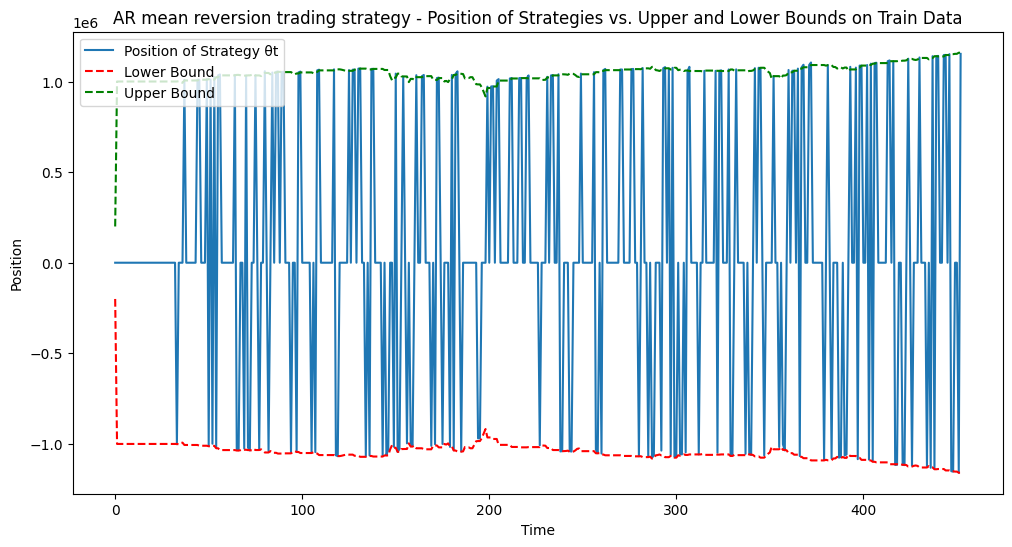

In [34]:
# Position of the strategies θt together with the upper and lower bounds
t = np.arange(len(test_df_ar))
plt.figure(figsize=(12,6))
plt.plot(t, test_df_ar['theta'], label='Position of Strategy θt')
plt.plot(t, -test_df_ar['vt'], 'r--', label='Lower Bound')
plt.plot(t, test_df_ar['vt'], 'g--', label='Upper Bound')
plt.legend(loc='upper left')
plt.title('AR mean reversion trading strategy - Position of Strategies vs. Upper and Lower Bounds on Train Data')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

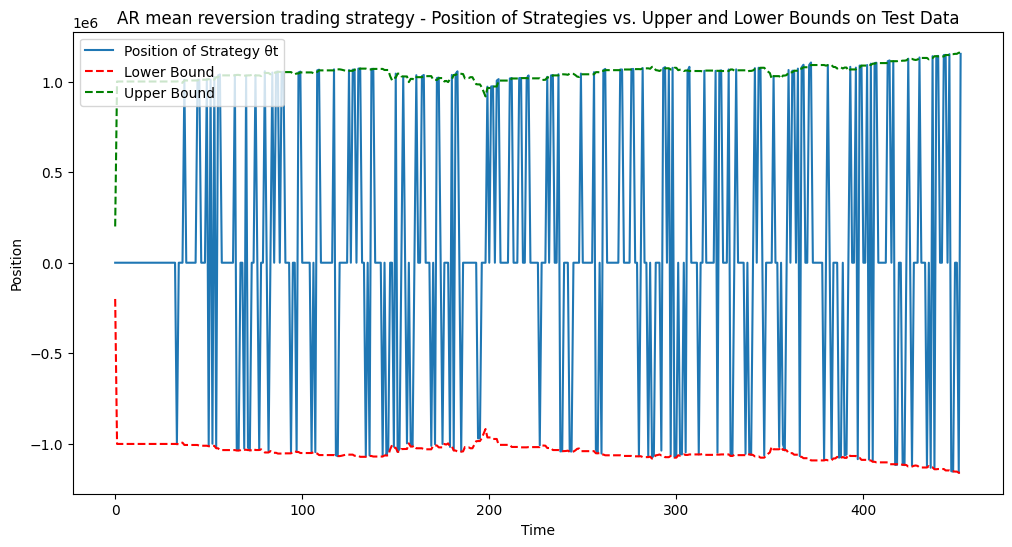

In [35]:
t = np.arange(len(test_df_ar))
plt.figure(figsize=(12,6))
plt.plot(t, test_df_ar['theta'], label='Position of Strategy θt')
plt.plot(t, -test_df_ar['vt'], 'r--', label='Lower Bound')
plt.plot(t, test_df_ar['vt'], 'g--', label='Upper Bound')
plt.legend(loc='upper left')
plt.title('AR mean reversion trading strategy - Position of Strategies vs. Upper and Lower Bounds on Test Data')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

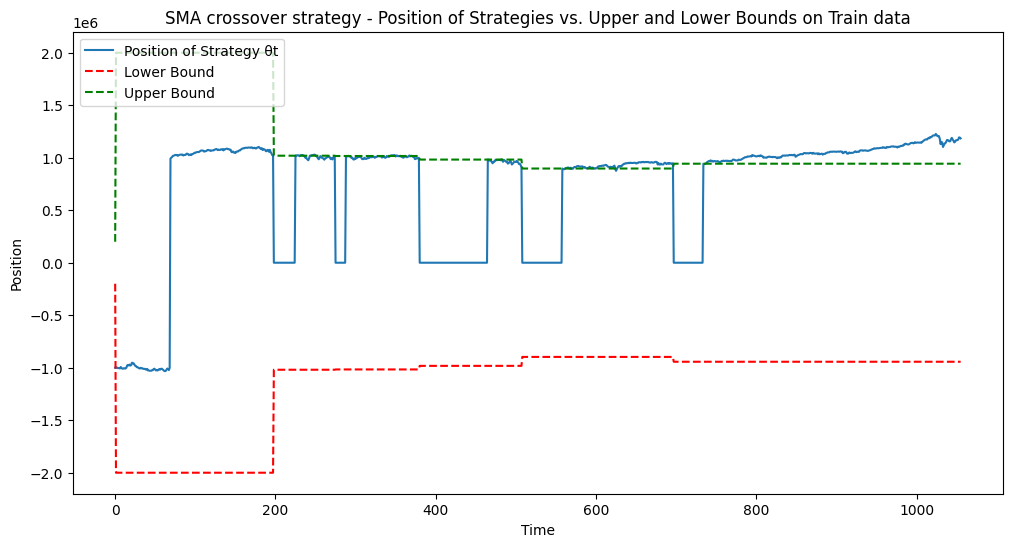

In [36]:
t = np.arange(len(train_df_sma))
plt.figure(figsize=(12,6))
plt.plot(t, train_df_sma['theta'], label='Position of Strategy θt')
plt.plot(t, -train_df_sma['vt'], 'r--', label='Lower Bound')
plt.plot(t, train_df_sma['vt'], 'g--', label='Upper Bound')
plt.legend(loc='upper left')
plt.title('SMA crossover strategy - Position of Strategies vs. Upper and Lower Bounds on Train data')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

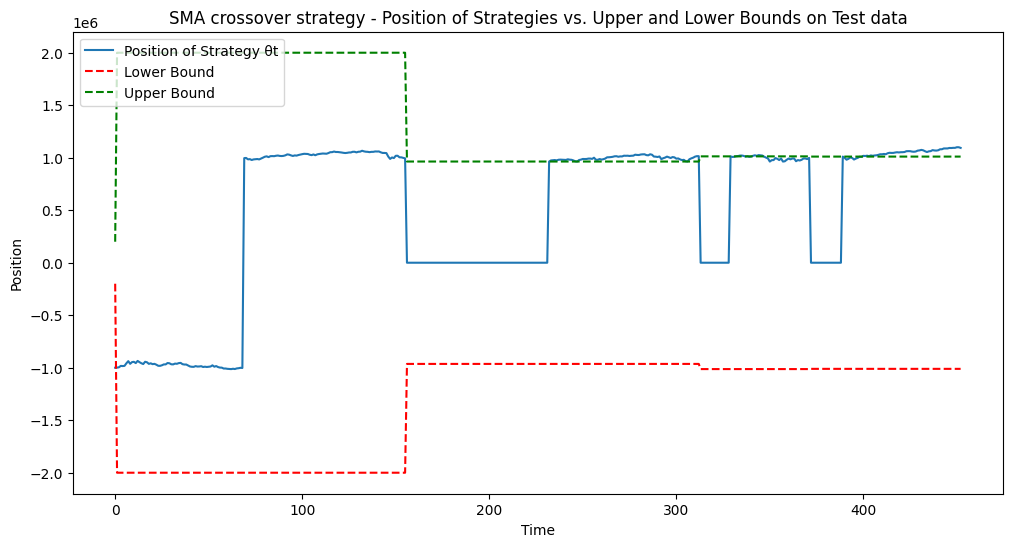

In [37]:
t = np.arange(len(test_df_sma))
plt.figure(figsize=(12,6))
plt.plot(t, test_df_sma['theta'], label='Position of Strategy θt')
plt.plot(t, -test_df_sma['vt'], 'r--', label='Lower Bound')
plt.plot(t, test_df_sma['vt'], 'g--', label='Upper Bound')
plt.legend(loc='upper left')
plt.title('SMA crossover strategy - Position of Strategies vs. Upper and Lower Bounds on Test data')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

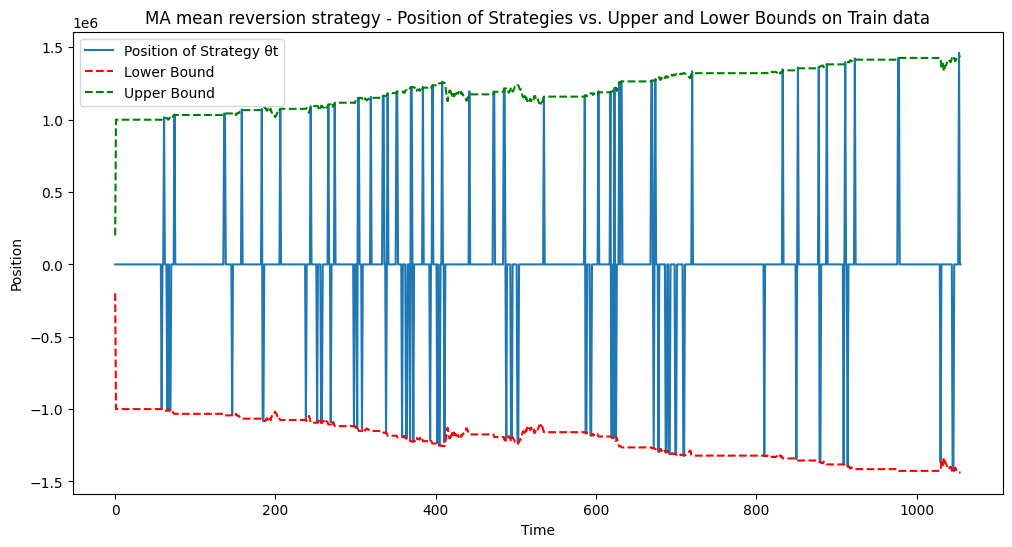

In [38]:
t = np.arange(len(train_df_mr))
plt.figure(figsize=(12,6))
plt.plot(t, train_df_mr['theta'], label='Position of Strategy θt')
plt.plot(t, -train_df_mr['vt'], 'r--', label='Lower Bound')
plt.plot(t, train_df_mr['vt'], 'g--', label='Upper Bound')
plt.legend(loc='upper left')
plt.title('MA mean reversion strategy - Position of Strategies vs. Upper and Lower Bounds on Train data')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

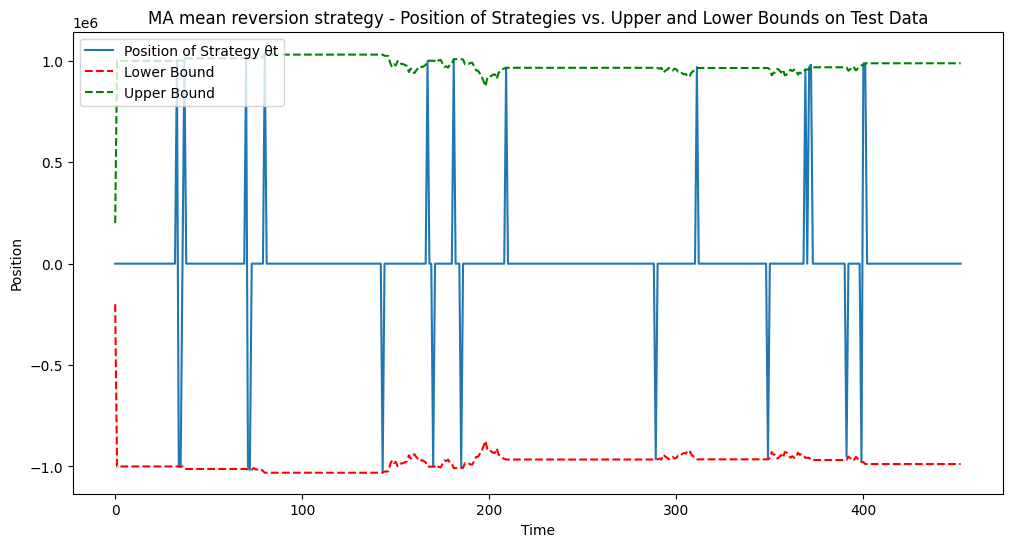

In [39]:
# Position of the strategies θt together with the upper and lower bounds
t = np.arange(len(test_df_mr))
plt.figure(figsize=(12,6))
plt.plot(t, test_df_mr['theta'], label='Position of Strategy θt')
plt.plot(t, -test_df_mr['vt'], 'r--', label='Lower Bound')
plt.plot(t, test_df_mr['vt'], 'g--', label='Upper Bound')
plt.legend(loc='upper left')
plt.title('MA mean reversion strategy - Position of Strategies vs. Upper and Lower Bounds on Test Data')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

Calculate the turnover in dollar value traded over time. Additionally calculate the turnover in number of units traded over time.

In [40]:
def calc_turnover_dollars(df):
    lst = []
    for i in range(len(df)-1):
        lst.append(np.abs(df['theta'][i+1] - df['theta'][i]))
    turnover_dollars = sum(lst)
    return turnover_dollars

In [41]:
def calc_turnover_units(df):
    theta_over_price = df['theta'] /df['Close']
    turnover = np.sum(np.abs(np.diff(theta_over_price)))
    return turnover

In [42]:
print(f"Turnover in dollars over time for Train data with Autoregression mean reversion strategy: {calc_turnover_dollars(train_df_ar)}")
print(f"Turnover in dollars over time for Train data with Simple moving average crossover strategy: {calc_turnover_dollars(train_df_sma)}")
print(f"Turnover in dollars over time for Train data with Moving average mean reversion strategy: {calc_turnover_dollars(train_df_mr)}")
print('\n')
print(f"Turnover in dollars over time for Test data with Autoregression mean reversion strategy: {calc_turnover_dollars(test_df_ar)}")
print(f"Turnover in dollars over time for Test data with Simple moving average crossover strategy: {calc_turnover_dollars(test_df_sma)}")
print(f"Turnover in dollars over time for Test data with Moving average mean reversion strategy: {calc_turnover_dollars(test_df_mr)}")

Turnover in dollars over time for Train data with Autoregression mean reversion strategy: 740246814.1487446
Turnover in dollars over time for Train data with Simple moving average crossover strategy: 16020840.127208913
Turnover in dollars over time for Train data with Moving average mean reversion strategy: 196681517.3526133


Turnover in dollars over time for Test data with Autoregression mean reversion strategy: 297418038.0630053
Turnover in dollars over time for Test data with Simple moving average crossover strategy: 9935148.57492093
Turnover in dollars over time for Test data with Moving average mean reversion strategy: 39673245.76538005


In [43]:
print(f"Turnover units over time for Train data with Autoregression mean reversion strategy: {calc_turnover_units(train_df_ar)}")
print(f"Turnover units over time for Train data with Simple moving average crossover strategy: {calc_turnover_units(train_df_sma)}")
print(f"Turnover units over time for Train data with Moving average mean reversion strategy: {calc_turnover_units(train_df_mr)}")
print('\n')
print(f"Turnover units over time for Test data with Autoregression mean reversion strategy: {calc_turnover_units(test_df_ar)}")
print(f"Turnover units over time for Test data with Simple moving average crossover strategy: {calc_turnover_units(test_df_sma)}")
print(f"Turnover units over time for Test data with Moving average mean reversion strategy: {calc_turnover_units(test_df_mr)}")

Turnover units over time for Train data with Autoregression mean reversion strategy: 3423733.9991108095
Turnover units over time for Train data with Simple moving average crossover strategy: 58268.05832646189
Turnover units over time for Train data with Moving average mean reversion strategy: 920745.9113311081


Turnover units over time for Test data with Autoregression mean reversion strategy: 1040806.634270541
Turnover units over time for Test data with Simple moving average crossover strategy: 28115.981377240136
Turnover units over time for Test data with Moving average mean reversion strategy: 141915.95618101303


(c) Create a total PnL series for the strategies, where we assume that unused capital will be put in a money-market and grow at the same risk-free rate, i.e., the value of your account changes by the trading PnL (∆V ) and the change in the growth of the money-market capital account (∆V cap).


In [53]:
def create_pnl_series(df, initial_capital=200000, leverage=5, L=1):
    num_days = len(df)
    V = np.zeros(num_days)
    V_cap = np.zeros(num_days)
    V_total = np.zeros(num_days)
    total_val = np.zeros(num_days)
    total_val[0] = initial_capital
    bounds = np.zeros((num_days, 2))

    excess_returns = df['excess_return'].values
    rf_values = df['value'].values.astype(float)

    for t in range(1, num_days):
        theta_t = df['theta'][t]
        margin = abs(theta_t)
        daily_return = excess_returns[t]
        rf = rf_values[t]

        V[t] = (daily_return - rf) * theta_t
        V_cap[t] = (total_val[t - 1] - margin * initial_capital) * rf / initial_capital
        V_total[t] = V[t] + V_cap[t]
        total_val[t] = total_val[t - 1] + V_total[t] / leverage

    return V, V_cap, V_total


In [54]:
V_train_mr, V_cap_train_mr, V_total_train_mr = create_pnl_series(train_df_mr)
V_train_sma, V_cap_train_sma, V_total_train_sma = create_pnl_series(train_df_sma)
V_train_ar, V_cap_train_ar, V_total_train_ar = create_pnl_series(train_df_ar)

V_test_mr, V_cap_test_mr, V_total_test_mr = create_pnl_series(test_df_mr)
V_test_sma, V_cap_test_sma, V_total_test_sma = create_pnl_series(test_df_sma)
V_test_ar, V_cap_test_ar, V_total_test_ar = create_pnl_series(test_df_ar)

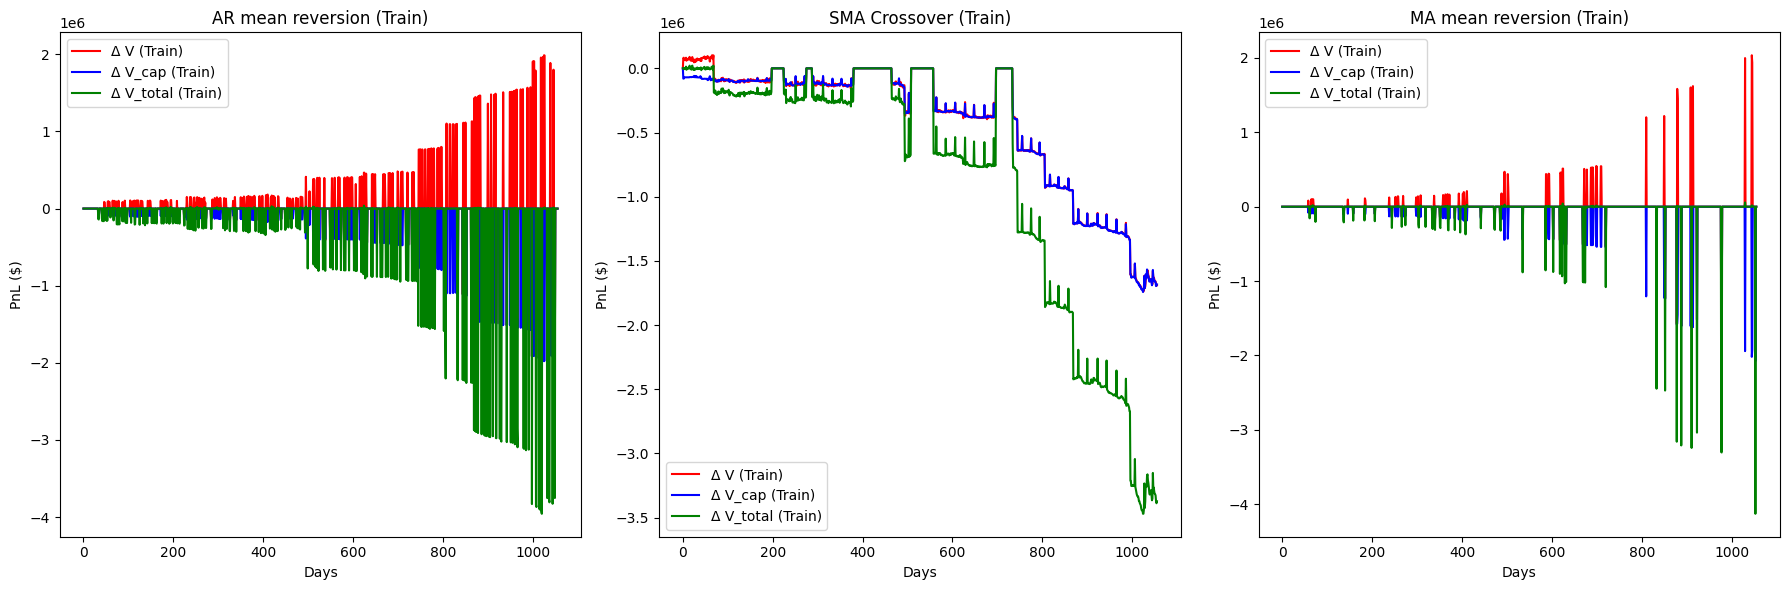

In [55]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

# Plot AR mean reversion strategy
axs[0].plot(V_train_ar, label='\u0394 V (Train)', color='red')
axs[0].plot(V_cap_train_ar, label='\u0394 V_cap (Train)', color='blue')
axs[0].plot(V_total_train_ar, label='\u0394 V_total (Train)', color='green')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('PnL ($)')
axs[0].set_title('AR mean reversion (Train)')
axs[0].legend()

# Plot Simple Moving Crossover strategy
axs[1].plot(V_train_sma, label='\u0394 V (Train)', color='red')
axs[1].plot(V_cap_train_sma, label='\u0394 V_cap (Train)', color='blue')
axs[1].plot(V_total_train_sma, label='\u0394 V_total (Train)', color='green')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('PnL ($)')
axs[1].set_title('SMA Crossover (Train)')
axs[1].legend()

# Plot MA mean reversion strategy
axs[2].plot(V_train_mr, label='\u0394 V (Train)', color='red')
axs[2].plot(V_cap_train_mr, label='\u0394 V_cap (Train)', color='blue')
axs[2].plot(V_total_train_mr, label='\u0394 V_total (Train)', color='green')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('PnL ($)')
axs[2].set_title('MA mean reversion (Train)')
axs[2].legend()

plt.tight_layout()
plt.show()


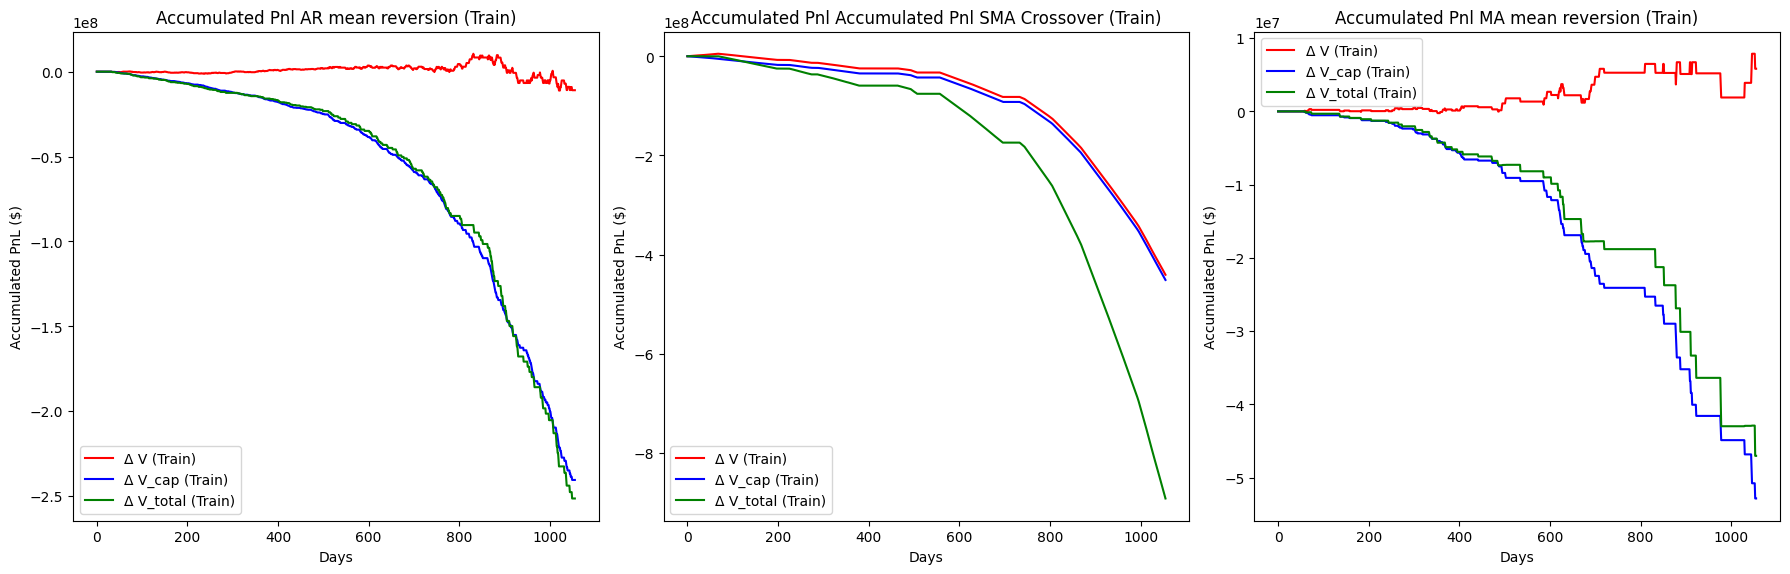

In [56]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

# Plot AR mean reversion strategy
axs[0].plot(np.cumsum(V_train_ar), label='\u0394 V (Train)', color='red')
axs[0].plot(np.cumsum(V_cap_train_ar), label='\u0394 V_cap (Train)', color='blue')
axs[0].plot(np.cumsum(V_total_train_ar), label='\u0394 V_total (Train)', color='green')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Accumulated PnL ($)')
axs[0].set_title('Accumulated Pnl AR mean reversion (Train)')
axs[0].legend()

# Plot Simple Moving Crossover strategy
axs[1].plot(np.cumsum(V_train_sma), label='\u0394 V (Train)', color='red')
axs[1].plot(np.cumsum(V_cap_train_sma), label='\u0394 V_cap (Train)', color='blue')
axs[1].plot(np.cumsum(V_total_train_sma), label='\u0394 V_total (Train)', color='green')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Accumulated PnL ($)')
axs[1].set_title('Accumulated Pnl Accumulated Pnl SMA Crossover (Train)')
axs[1].legend()

# Plot MA mean reversion strategy
axs[2].plot(np.cumsum(V_train_mr), label='\u0394 V (Train)', color='red')
axs[2].plot(np.cumsum(V_cap_train_mr), label='\u0394 V_cap (Train)', color='blue')
axs[2].plot(np.cumsum(V_total_train_mr), label='\u0394 V_total (Train)', color='green')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('Accumulated PnL ($)')
axs[2].set_title('Accumulated Pnl MA mean reversion (Train)')
axs[2].legend()

plt.tight_layout()
plt.show()

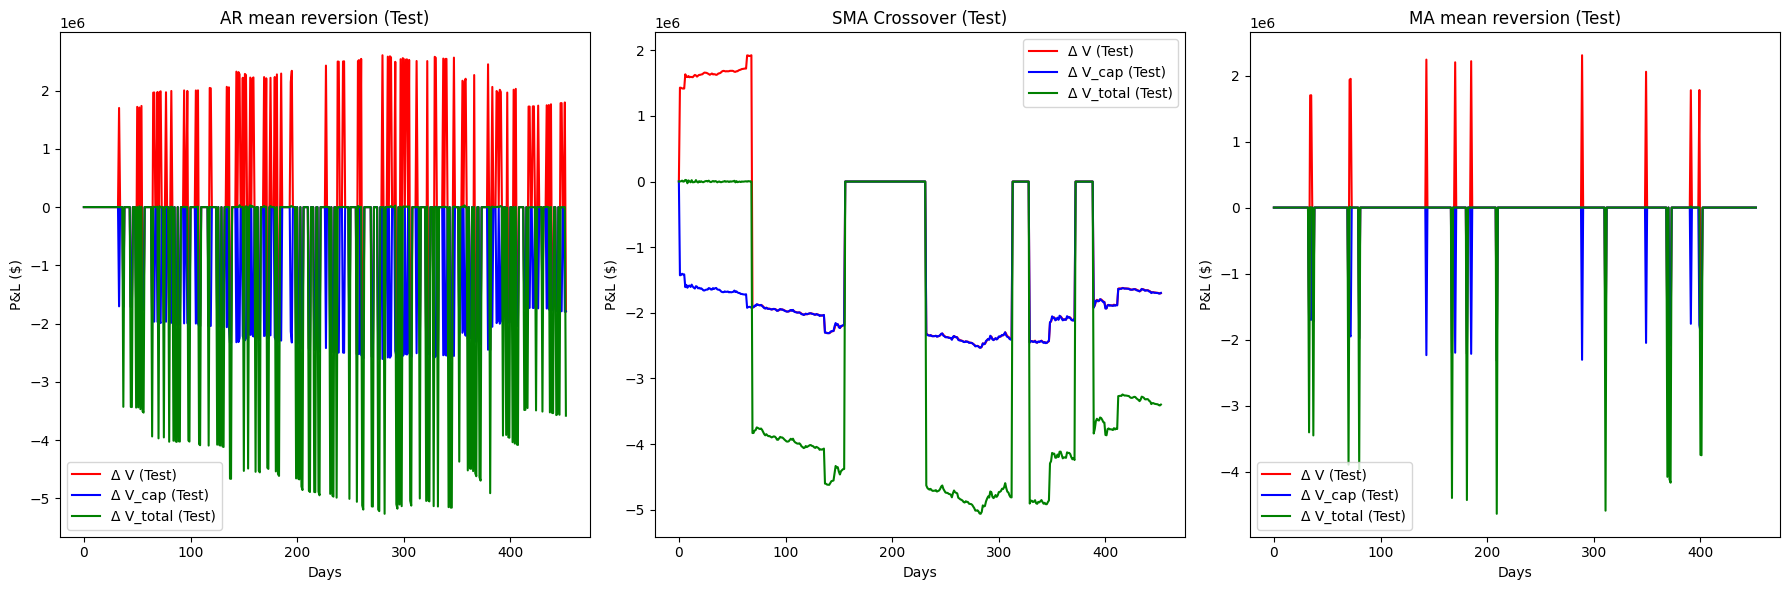

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

# Plot Mean reversion strategy
axs[0].plot(V_test_ar, label = '\u0394 V (Test)', color='red')
axs[0].plot(V_cap_test_ar, label = '\u0394 V_cap (Test)', color='blue')
axs[0].plot(V_total_test_ar, label = '\u0394 V_total (Test)', color='green')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('P&L ($)')
axs[0].set_title('AR mean reversion (Test)')
axs[0].legend()

# Plot Simple Moving Crossover strategy
axs[1].plot(V_test_sma, label = '\u0394 V (Test)', color='red')
axs[1].plot(V_cap_test_sma, label = '\u0394 V_cap (Test)', color='blue')
axs[1].plot(V_total_test_sma, label = '\u0394 V_total (Test)', color='green')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('P&L ($)')
axs[1].set_title('SMA Crossover (Test)')
axs[1].legend()

# Plot MA mean reversion strategy
axs[2].plot(V_test_mr, label = '\u0394 V (Test)', color='red')
axs[2].plot(V_cap_test_mr, label = '\u0394 V_cap (Test)', color='blue')
axs[2].plot(V_total_test_mr, label = '\u0394 V_total (Test)', color='green')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('P&L ($)')
axs[2].set_title('MA mean reversion (Test)')
axs[2].legend()

plt.tight_layout()
plt.show()


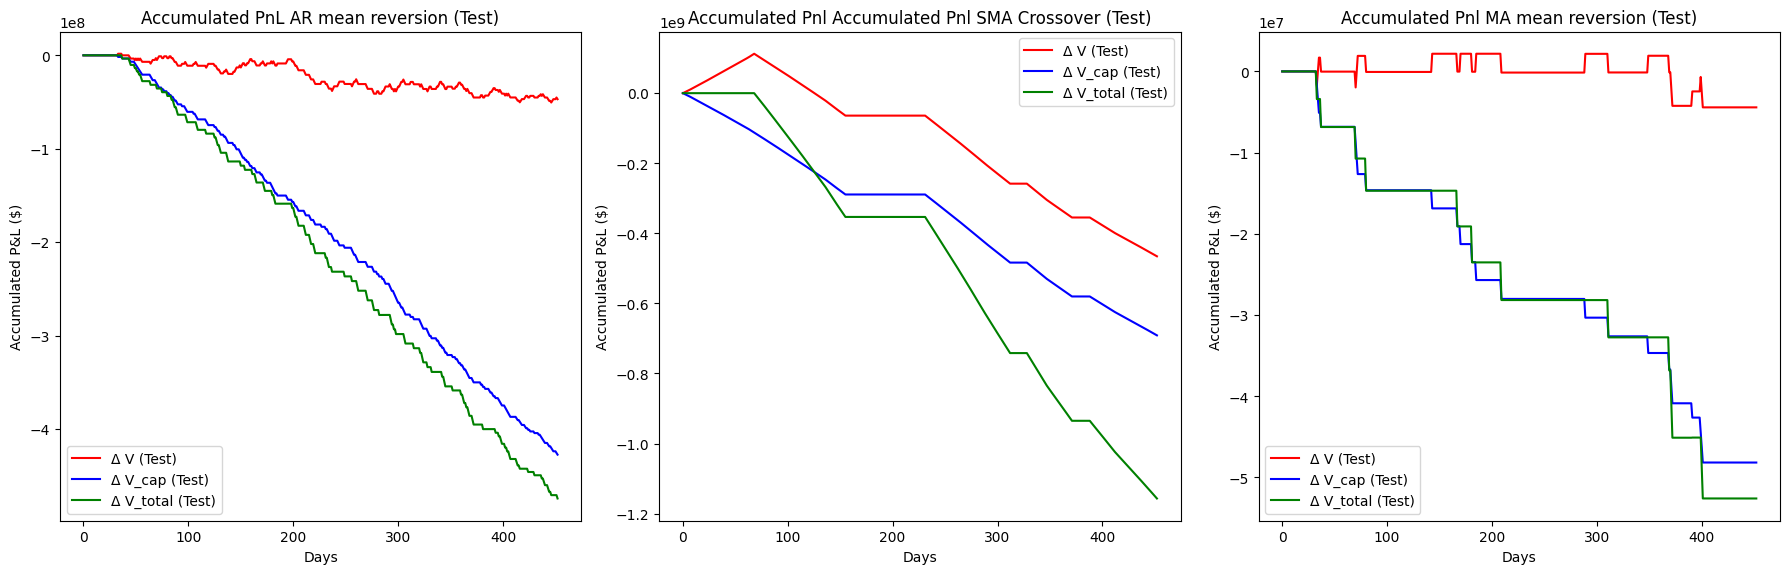

In [58]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

# Plot Mean reversion strategy
axs[0].plot(np.cumsum(V_test_ar), label = '\u0394 V (Test)', color='red')
axs[0].plot(np.cumsum(V_cap_test_ar), label = '\u0394 V_cap (Test)', color='blue')
axs[0].plot(np.cumsum(V_total_test_ar), label = '\u0394 V_total (Test)', color='green')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Accumulated P&L ($)')
axs[0].set_title('Accumulated PnL AR mean reversion (Test)')
axs[0].legend()

# Plot Simple Moving Crossover strategy
axs[1].plot(np.cumsum(V_test_sma), label = '\u0394 V (Test)', color='red')
axs[1].plot(np.cumsum(V_cap_test_sma), label = '\u0394 V_cap (Test)', color='blue')
axs[1].plot(np.cumsum(V_total_test_sma), label = '\u0394 V_total (Test)', color='green')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Accumulated P&L ($)')
axs[1].set_title('Accumulated Pnl Accumulated Pnl SMA Crossover (Test)')
axs[1].legend()

# Plot MA mean reversion strategy
axs[2].plot(np.cumsum(V_test_mr), label = '\u0394 V (Test)', color='red')
axs[2].plot(np.cumsum(V_cap_test_mr), label = '\u0394 V_cap (Test)', color='blue')
axs[2].plot(np.cumsum(V_total_test_mr), label = '\u0394 V_total (Test)', color='green')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('Accumulated P&L ($)')
axs[2].set_title('Accumulated Pnl MA mean reversion (Test)')
axs[2].legend()

plt.tight_layout()
plt.show()

(a) Define the excess return of a trading strategy as the daily trading PnL, PnLt = ∆Vt. Use this quantity to compute the Sharpe Ratio (SR), Sortino Ratio, Maximum Drawdown and the Calmar ratio of your strategies.

In [59]:
def calc_sharpe_ratio(df):
    mean_ret = df['pnl'].mean()
    std_ret = df['pnl'].std()
    return mean_ret / std_ret

In [60]:
def calc_sortino_ratio(df):
    mean_ret = df['pnl'].mean()
    downside_dev = df['pnl'][df['pnl'] < 0].std()
    return mean_ret / downside_dev

In [62]:
def calc_max_drawdown(df):
    pnl = df['pnl'].fillna(0)
    cum_returns = np.cumsum(pnl)
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = np.zeros(len(cum_returns))
    non_zero_max = running_max > 0
    if any(non_zero_max):
        drawdown[non_zero_max] = (cum_returns[non_zero_max] - running_max[non_zero_max]) / running_max[non_zero_max]

    return np.min(drawdown)

In [64]:
def calc_calmar_ratio(df, max_drawdown):
    pnl = df['pnl'].fillna(0)
    cum_returns = np.cumsum(pnl)
    pct_returns = pnl / cum_returns

    return np.sum(pct_returns) / abs(max_drawdown)

In [65]:
print(f"Sharpe Ratio for Train data with Autoregression mean reversion strategy: {calc_sharpe_ratio(train_df_ar)}")
print(f"Sharpe Ratio for Train data with Simple moving average crossover strategy: {calc_sharpe_ratio(train_df_sma)}")
print(f"Sharpe Ratio for Train data with Moving average mean reversion strategy: {calc_sharpe_ratio(train_df_mr)}")
print('\n')
print(f"Sharpe Ratio for Test data with Autoregression mean reversion strategy: {calc_sharpe_ratio(test_df_ar)}")
print(f"Sharpe Ratio for Test data with Simple moving average crossover strategy: {calc_sharpe_ratio(test_df_sma)}")
print(f"Sharpe Ratio for Test data with Moving average mean reversion strategy: {calc_sharpe_ratio(test_df_mr)}")

Sharpe Ratio for Train data with Autoregression mean reversion strategy: 0.4339679609879601
Sharpe Ratio for Train data with Simple moving average crossover strategy: 0.03322126317159618
Sharpe Ratio for Train data with Moving average mean reversion strategy: 0.17739006071918906


Sharpe Ratio for Test data with Autoregression mean reversion strategy: 0.463184108978322
Sharpe Ratio for Test data with Simple moving average crossover strategy: 0.03404672177662918
Sharpe Ratio for Test data with Moving average mean reversion strategy: 0.14718258700215453


In [66]:
print(f"Sortino Ratio for Train data with Autoregression mean reversion strategy: {calc_sortino_ratio(train_df_ar)}")
print(f"Sortino Ratio for Train data with Simple moving average crossover strategy: {calc_sortino_ratio(train_df_sma)}")
print(f"Sortino Ratio for Train data with Moving average mean reversion strategy: {calc_sortino_ratio(train_df_mr)}")
print('\n')
print(f"Sortino Ratio for Test data with Autoregression mean reversion strategy: {calc_sortino_ratio(test_df_ar)}")
print(f"Sortino Ratio for Test data with Simple moving average crossover strategy: {calc_sortino_ratio(test_df_sma)}")
print(f"Sortino Ratio for Test data with Moving average mean reversion strategy: {calc_sortino_ratio(test_df_mr)}")

Sortino Ratio for Train data with Autoregression mean reversion strategy: 0.8820609119983344
Sortino Ratio for Train data with Simple moving average crossover strategy: 0.037676993183612
Sortino Ratio for Train data with Moving average mean reversion strategy: 0.1783284147519506


Sortino Ratio for Test data with Autoregression mean reversion strategy: 1.3617396796833376
Sortino Ratio for Test data with Simple moving average crossover strategy: 0.0382940353541362
Sortino Ratio for Test data with Moving average mean reversion strategy: 0.32271872157983694


In [68]:
print(f"Maximum drawdown for Train data with Autoregression mean reversion strategy: {calc_max_drawdown(train_df_ar)}")
print(f"Maximum drawdown for Train data with Simple moving average crossover strategy: {calc_max_drawdown(train_df_sma)}")
print(f"Maximum drawdown for Train data with Moving average mean reversion strategy: {calc_max_drawdown(train_df_mr)}")
print('\n')
print(f"Maximum drawdown for Test data with Autoregression mean reversion strategy: {calc_max_drawdown(test_df_ar)}")
print(f"Maximum drawdown for Test data with Simple moving average crossover strategy: {calc_max_drawdown(test_df_sma)}")
print(f"Maximum drawdown for Test data with Moving average mean reversion strategy: {calc_max_drawdown(test_df_mr)}")

Maximum drawdown for Train data with Autoregression mean reversion strategy: -0.1936504478750301
Maximum drawdown for Train data with Simple moving average crossover strategy: -3.19198170467829
Maximum drawdown for Train data with Moving average mean reversion strategy: -0.17567831235235082


Maximum drawdown for Test data with Autoregression mean reversion strategy: -0.253932938980037
Maximum drawdown for Test data with Simple moving average crossover strategy: -1.3344671469953109
Maximum drawdown for Test data with Moving average mean reversion strategy: -0.07349513883705953


In [69]:
print(f"Calmar Ratio for Train data with Autoregression mean reversion strategy: {calc_calmar_ratio(train_df_ar, calc_max_drawdown(train_df_ar))}")
print(f"Calmar Ratio for Train data with Simple moving average crossover strategy: {calc_calmar_ratio(train_df_sma, calc_max_drawdown(train_df_sma))}")
print(f"Calmar Ratio for Train data with Moving average mean reversion strategy: {calc_calmar_ratio(train_df_mr, calc_max_drawdown(train_df_mr))}")
print('\n')
print(f"Calmar Ratio for Test data with Autoregression mean reversion strategy: {calc_calmar_ratio(test_df_ar, calc_max_drawdown(test_df_ar))}")
print(f"Calmar Ratio for Test data with Simple moving average crossover strategy: {calc_calmar_ratio(test_df_sma, calc_max_drawdown(test_df_sma))}")
print(f"Calmar Ratio for Test data with Moving average mean reversion strategy: {calc_calmar_ratio(test_df_mr, calc_max_drawdown(test_df_mr))}")

Calmar Ratio for Train data with Autoregression mean reversion strategy: 31.518124104822263
Calmar Ratio for Train data with Simple moving average crossover strategy: 146.1260444954033
Calmar Ratio for Train data with Moving average mean reversion strategy: 31.547568510721984


Calmar Ratio for Test data with Autoregression mean reversion strategy: 32.62858219466907
Calmar Ratio for Test data with Simple moving average crossover strategy: 53.26423668706616
Calmar Ratio for Test data with Moving average mean reversion strategy: 53.87255009929723


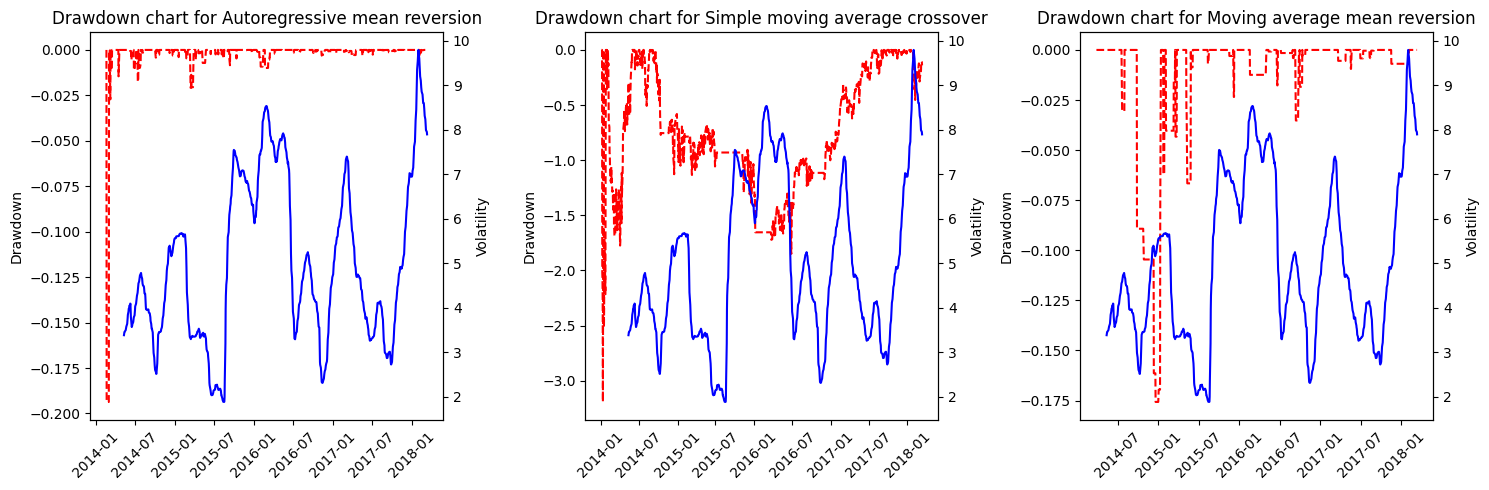

In [70]:
df1 = train_df_ar
df2 = train_df_sma
df3 = train_df_mr
strategy1_name = 'Autoregressive mean reversion'
strategy2_name = 'Simple moving average crossover'
strategy3_name = 'Moving average mean reversion'

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first strategy's drawdown chart
pnl1 = df1['pnl'].fillna(0)
cum_returns1 = np.cumsum(pnl1)
running_max1 = np.maximum.accumulate(cum_returns1)
drawdown1 = (cum_returns1 - running_max1) / running_max1
volatility1 = df1['Close'].rolling(window=90).std()
axes[0].plot(df1.index, drawdown1, '--', color ='red')
axes[0].set_ylabel('Drawdown')
axes[0].set_title(f'Drawdown chart for {strategy1_name}')
axes[0].tick_params(axis='x', labelrotation=45)
ax2_1 = axes[0].twinx()
ax2_1.plot(df1.index, volatility1, color='blue')
ax2_1.set_ylabel('Volatility')

# Plot the second strategy's drawdown chart
pnl2 = df2['pnl'].fillna(0)
cum_returns2 = np.cumsum(pnl2)
running_max2 = np.maximum.accumulate(cum_returns2)
drawdown2 = (cum_returns2 - running_max2) / running_max2
volatility2 = df2['Close'].rolling(window=90).std()
axes[1].plot(df2.index, drawdown2, '--', color ='red')
axes[1].set_ylabel('Drawdown')
axes[1].set_title(f'Drawdown chart for {strategy2_name}')
axes[1].tick_params(axis='x', labelrotation=45)
ax2_2 = axes[1].twinx()
ax2_2.plot(df2.index, volatility2, color='blue')
ax2_2.set_ylabel('Volatility')

# Plot the third strategy's drawdown chart
pnl3 = df3['pnl'].fillna(0)
cum_returns3 = np.cumsum(pnl3)
running_max3 = np.maximum.accumulate(cum_returns3)
drawdown3 = (cum_returns3 - running_max3) / running_max3
volatility3 = df3['Close'].rolling(window=90).std()
axes[2].plot(df3.index, drawdown3, '--', color ='red')
axes[2].set_ylabel('Drawdown')
axes[2].set_title(f'Drawdown chart for {strategy3_name}')
axes[2].tick_params(axis='x', labelrotation=45)
ax2_3 = axes[2].twinx()
ax2_3.plot(df3.index, volatility3, color='blue')
ax2_3.set_ylabel('Volatility')

plt.tight_layout()
plt.show()


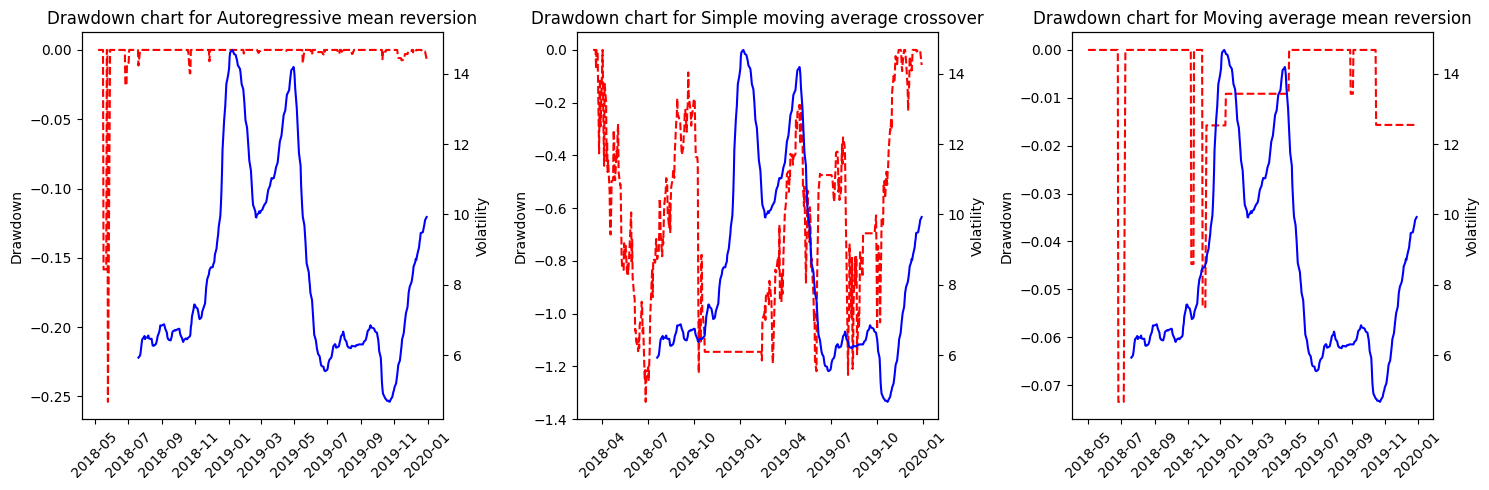

In [71]:
df1 = test_df_ar
df2 = test_df_sma
df3 = test_df_mr
strategy1_name = 'Autoregressive mean reversion'
strategy2_name = 'Simple moving average crossover'
strategy3_name = 'Moving average mean reversion'

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first strategy's drawdown chart
pnl1 = df1['pnl'].fillna(0)
cum_returns1 = np.cumsum(pnl1)
running_max1 = np.maximum.accumulate(cum_returns1)
drawdown1 = (cum_returns1 - running_max1) / running_max1
volatility1 = df1['Close'].rolling(window=90).std()
axes[0].plot(df1.index, drawdown1, '--', color ='red')
axes[0].set_ylabel('Drawdown')
axes[0].set_title(f'Drawdown chart for {strategy1_name}')
axes[0].tick_params(axis='x', labelrotation=45)
ax2_1 = axes[0].twinx()
ax2_1.plot(df1.index, volatility1, color='blue')
ax2_1.set_ylabel('Volatility')

# Plot the second strategy's drawdown chart
pnl2 = df2['pnl'].fillna(0)
cum_returns2 = np.cumsum(pnl2)
running_max2 = np.maximum.accumulate(cum_returns2)
drawdown2 = (cum_returns2 - running_max2) / running_max2
volatility2 = df2['Close'].rolling(window=90).std()
axes[1].plot(df2.index, drawdown2, '--', color ='red')
axes[1].set_ylabel('Drawdown')
axes[1].set_title(f'Drawdown chart for {strategy2_name}')
axes[1].tick_params(axis='x', labelrotation=45)
ax2_2 = axes[1].twinx()
ax2_2.plot(df2.index, volatility2, color='blue')
ax2_2.set_ylabel('Volatility')

# Plot the third strategy's drawdown chart
pnl3 = df3['pnl'].fillna(0)
cum_returns3 = np.cumsum(pnl3)
running_max3 = np.maximum.accumulate(cum_returns3)
drawdown3 = (cum_returns3 - running_max3) / running_max3
volatility3 = df3['Close'].rolling(window=90).std()
axes[2].plot(df3.index, drawdown3, '--', color ='red')
axes[2].set_ylabel('Drawdown')
axes[2].set_title(f'Drawdown chart for {strategy3_name}')
axes[2].tick_params(axis='x', labelrotation=45)
ax2_3 = axes[2].twinx()
ax2_3.plot(df3.index, volatility3, color='blue')
ax2_3.set_ylabel('Volatility')

plt.tight_layout()
plt.show()

(b) Plot the average excess returns of the strategies in the test set versus their standard deviations, include the SPDR average excess return and its standard deviation. Can you identify a linear combination of trading strategies with an higher Sharpe Ratio than the original ones?

In [72]:
strategy_avg_excess_returns = [test_df_ar['pnl'].mean(), test_df_sma['pnl'].mean(), test_df_mr['pnl'].mean()]
strategy_std = [test_df_ar['pnl'].std(), test_df_sma['pnl'].std(), test_df_mr['pnl'].std()]

In [73]:
spdr_avg_excess_returns = test_data['excess_return'].mean()
spdr_std = test_data['excess_return'].std()

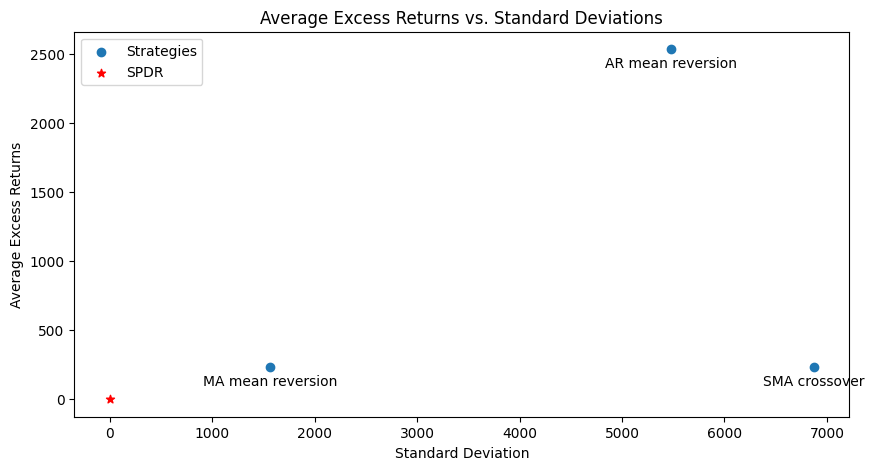

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(strategy_std, strategy_avg_excess_returns, label='Strategies')
ax.scatter(spdr_std, spdr_avg_excess_returns, label='SPDR', color='r', marker='*')

for i, txt in enumerate(['AR mean reversion', 'SMA crossover', 'MA mean reversion']):
    ax.annotate(txt, (strategy_std[i], strategy_avg_excess_returns[i]), textcoords="offset points", xytext=(0,-13), ha='center')

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Average Excess Returns')
ax.set_title('Average Excess Returns vs. Standard Deviations')
ax.legend(loc='upper left')
plt.show()